In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
from collections import deque
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import math

Instructions for updating:
non-resource variables are not supported in the long term


ref: https://github.com/ChefLiutao/Time-series-forecasting-via-deep-reinforcement-learning 

In [2]:
raw_df = pd.read_csv('/Users/hecate/Downloads/EU-TRAVEL.csv')
for col in raw_df.columns[1:]:
    raw_df[col] = raw_df[col].fillna(raw_df[col].rolling(200, min_periods=1).median()) 
raw_df['PRICE'] = raw_df['PRICE'].interpolate()

data1 = raw_df.iloc[0:,3]
data = data1.reset_index(drop=True)

In [3]:
def build_s_a(sequence,n,m):
    '''
    Args:
        sequence: Time series data
        n: The number of historical data denoting the current state
        m: The number of prediction steps in advance
    Return:
        state_mat: A matrix contains all states at each time step
        best_action: The optimal action based on each state
    '''
    n_rows = len(sequence)-n-m+1
    state_mat = np.zeros((n_rows,n))
    best_action = np.zeros(n_rows)
    for i in range(n_rows):
        state_mat[i] = sequence[i:(i+n)]
        #print(str(i) + ' ' + str(i+n+m-1))
       #print(i+n+m-1)
        #import pdb;pdb.set_trace()
        best_action[i] = sequence[i+n+m-1]
    return state_mat,best_action



def normalization(traindata,testdata):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(traindata)
    traindata_scaled = scaler.transform(traindata)
    testdata_scaled = scaler.transform(testdata)
    
    return traindata_scaled,testdata_scaled 

In [4]:
class DDPG():
    def __init__(self,
                 n_features,
#                 n_actions,
                 a_low,
                 a_high,
                 learning_rate_actor,
                 learning_rate_critic,
                 n_actor_hidden,
                 n_critic_hidden,
                 gamma = 0.9,
                 noise_varience = 3,
                 soft_replace = 0.1,
                 memory_size = 1000,
                 batch_size = 128):
        self.n_features = n_features             #dimension of states
#        self.n_actions = n_actions        
        self.a_low = a_low                       #The low bound of action sapce
        self.a_high = a_high                     #The high bound of action space
        self.lr_a = learning_rate_actor          #Learning rate of Actor NN
        self.lr_c = learning_rate_critic         #Learning rate of Critic NN
        self.n_actor_hidden = n_actor_hidden     #Number of hidden layer neurons in Actor
        self.n_critic_hidden = n_critic_hidden   #Number of hidden layer neurons in Critic
        self.gamma = gamma                       #Reward discount rate
        self.noise_var = noise_varience          #Variance of output action distribution
        self.soft_replace = soft_replace         #Update speed of target networks
        self.memory_size = memory_size           #Size of experience replay buffer
        self.memory = deque(maxlen = self.memory_size)   #Experience replay buffer
        self.batch_size = batch_size                     
        
        self.s = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.s_ = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.r = tf.placeholder(dtype = tf.float32,shape = [None,])
        self.done = tf.placeholder(dtype = tf.float32,shape = [None,]) # 0 if s_ == terminal else 1
        
        self.a = self.build_Actor1()
        self.a_ = self.build_Actor2()
        self.q_sa = self.build_Critic1()      #shape:[None,] 
        self.q_s_a_ = self.build_Critic2()    #shape:[None,]
        
        self.curr_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Current')
        self.targ_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Target')
        self.curr_c_params= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Current')
        self.targ_c_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Target')
        
        # Soft replace of Targets NN parameters
        self.replace_a_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_a_params,self.curr_a_params)]
        self.replace_c_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_c_params,self.curr_c_params)]
        
        self.td_error = self.r + self.gamma*self.q_s_a_ - self.q_sa
        self.critic_loss = tf.reduce_mean(tf.square(self.td_error))
        self.actor_loss = -tf.reduce_mean(self.q_sa)
        
        self.actor_train_op = tf.train.AdamOptimizer(self.lr_a).minimize(self.actor_loss,
                                                    var_list = self.curr_a_params)
        self.critic_train_op = tf.train.AdamOptimizer(self.lr_c).minimize(self.critic_loss,
                                                     var_list = self.curr_c_params)
        
        self.learn_step_counter = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def build_Actor1(self):
        '''
        Building Current Actor network.
        '''
        with tf.variable_scope('Actor/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable(name = 'w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s,w1) + b1)
            a = tf.matmul(hidden,w2) + b2
        return a[:,0]
#            return np.clip(np.random.normal(a,self.noise_var),self.a_low,self.a_high)
    
    def build_Actor2(self):
        '''
        Building Target Actor network.
        '''
        with tf.variable_scope('Actor/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable('w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            hidden = tf.nn.relu(tf.matmul(self.s_,w1) + b1)
            a_ = tf.matmul(hidden,w2) + b2
        return a_[:,0]
    
    def build_Critic1(self):
        '''
        Building Current Critic network.
        '''
        with tf.variable_scope('Critic/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1_s = tf.get_variable('w1_s',shape = [self.n_features,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            w1_a = tf.get_variable('w1_a',shape = [1,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b1 = tf.get_variable('b1',shape = [self.n_critic_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            w2 = tf.get_variable('w2',shape = [self.n_critic_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b2 = tf.get_variable('b2',shape = [1,],dtype = tf.float32,
                                 initializer = b_init,trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s,w1_s) + tf.matmul(self.a[:,np.newaxis],w1_a) + b1)
            q_sa = tf.matmul(hidden,w2) + b2
        return q_sa[:,0]
    
    def build_Critic2(self):
        '''
        Building Target Critic network.
        '''
        with tf.variable_scope('Critic/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1_s = tf.get_variable('w1_s',shape = [self.n_features,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            w1_a = tf.get_variable('w1_a',shape = [1,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b1 = tf.get_variable('b1',shape = [self.n_critic_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            w2 = tf.get_variable('w2',shape = [self.n_critic_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b2 = tf.get_variable('b2',shape = [1,],dtype = tf.float32,
                                 initializer = b_init,trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s_,w1_s) + tf.matmul(self.a_[:,np.newaxis],w1_a) + b1)
            q_s_a_ = tf.matmul(hidden,w2) + b2 
        return q_s_a_[:,0]            
    
    def choose_action(self,state):
        state = np.reshape(state,[-1,self.n_features])
        action = self.sess.run(self.a,feed_dict = {self.s:state})
        return action
    
    def store_transition(self,state,action,reward,next_state):
        state,next_state = state[np.newaxis,:],next_state[np.newaxis,:]
        action,reward = np.array(action),np.array(reward)
        action = np.reshape(action,[1,-1])
        reward = np.reshape(reward,[1,-1])
#        is_done = np.reshape(is_done,[1,-1])
        
        transition = np.concatenate((state,action,reward,next_state),axis = 1)
        self.memory.append(transition[0,:])
    



    def learn(self):
        if len(self.memory) == self.memory_size:
            if self.learn_step_counter % 200 == 0:
                self.sess.run((self.replace_a_params, self.replace_c_params))

            self.noise_var *= 0.999

            batch = np.array(random.sample(self.memory, self.batch_size))
            batch_s = batch[:, :self.n_features]
            batch_a = batch[:, self.n_features:(self.n_features + 1)][:, 0]
            batch_r = batch[:, (self.n_features + 1):(self.n_features + 2)][:, 0]
            batch_s_ = batch[:, (self.n_features + 2):(self.n_features*2 + 2)]

            # Update the Actor network
            self.sess.run(self.actor_train_op, feed_dict={self.s: batch_s})

            # Update the Critic network
            self.sess.run(self.critic_train_op, feed_dict={self.s: batch_s,
                                                        self.a: batch_a,
                                                        self.s_: batch_s_,
                                                        self.r: batch_r})

            # Calculate the Critic loss (MSE)
            critic_loss = self.sess.run(self.critic_loss, feed_dict={self.s: batch_s,
                                                                    self.a: batch_a,
                                                                    self.s_: batch_s_,
                                                                    self.r: batch_r})

            # Increment the learning step counter
            self.learn_step_counter += 1

            return critic_loss


In [5]:
N_FEATURES = 15
A_LOW = 0
A_HIGH = 1
LR_A = 0.001
LR_C = 0.003
N_ACTOR_HIDDEN = 30
N_CRITIC_HIDDEN = 30
MAX_EPISODES = 130
MAX_STEPS = 1000

GAMMA = 0.9                # discount factor 
TAU = 0.1                 # update factor
MEMORY_CAPACITY = 100000    # MEMORY
BATCH_SIZE = 128            # Batch gradient descent of m
beta = 0.5     #Momentum weights

In [6]:
#Build state matrix and best action
state,action = build_s_a(data,N_FEATURES,1)

#Data split
SPLIT_RATE = 0.8
split_index = round(len(state)*SPLIT_RATE)
train_s,train_a = state[:split_index],action[:split_index]
test_s,test_a = state[split_index:],action[split_index:]

#Normalization
train_s_scaled,test_s_scaled = normalization(train_s,test_s)
A,B = train_a.max(),train_a.min()
train_a_scaled,test_a_scaled = (train_a-B)/(A-B),(test_a-B)/(A-B)
Momentum = 0
ep_reward_sum = 0
n = 1

In [7]:
# Training
eps = []
mean_reward = []
critic_losses = []  # Initialize an empty list to store the Critic losses

ddpg = DDPG(N_FEATURES, A_LOW, A_HIGH, LR_A, LR_C, N_ACTOR_HIDDEN, N_CRITIC_HIDDEN)

for episode in range(MAX_EPISODES):
    index = np.random.choice(range(len(train_s_scaled)))
    s = train_s_scaled[index]
    ep_reward = 0
    ep_critic_loss = 0  # Initialize the episode's Critic loss

    for step in range(MAX_STEPS):
        a = ddpg.choose_action(s)
        r = -abs(a - train_a_scaled[index])
        ep_reward += r
        index += 1
        s_ = train_s_scaled[index]
        ddpg.store_transition(s, a, r, s_)
        ddpg.learn()

        if (index == len(train_s_scaled) - 1) or (step == MAX_STEPS - 1):
            ep_reward_sum = ep_reward_sum + ep_reward
            Momentum = beta * Momentum + (1 - beta) * ep_reward
            mean = ep_reward_sum / n
            n = n + 1
            eps.append(episode)
            mean_reward.append(mean)
            critic_losses.append(ddpg.learn())
            print('Episode %d : %.2f , Momentum : %.2f, Mean : %.2f' % (episode, ep_reward, Momentum, mean))
            break

        s = s_



# Testing
pred = []
for i in range(len(test_s_scaled)):
    state = test_s_scaled[i]
    action = ddpg.choose_action(state)
    pred.append(action)

pred = [pred[i][0] for i in range(len(test_s_scaled))]
pred = pd.Series(pred)
pred = pred*(A-B)+B
actual = pd.Series(test_a)


2023-09-02 18:14:53.937082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Episode 0 : -587.55 , Momentum : -293.77, Mean : -587.55
Episode 1 : -380.33 , Momentum : -337.05, Mean : -483.94
Episode 2 : -24.11 , Momentum : -180.58, Mean : -330.66
Episode 3 : -18.77 , Momentum : -99.67, Mean : -252.69
Episode 4 : -9.62 , Momentum : -54.65, Mean : -204.08
Episode 5 : -18.55 , Momentum : -36.60, Mean : -173.16
Episode 6 : -27.03 , Momentum : -31.82, Mean : -152.28
Episode 7 : -10.11 , Momentum : -20.96, Mean : -134.51
Episode 8 : -12.45 , Momentum : -16.71, Mean : -120.95
Episode 9 : -17.41 , Momentum : -17.06, Mean : -110.60
Episode 10 : -18.71 , Momentum : -17.89, Mean : -102.24
Episode 11 : -14.12 , Momentum : -16.01, Mean : -94.90
Episode 12 : -25.93 , Momentum : -20.97, Mean : -89.59
Episode 13 : -19.02 , Momentum : -19.99, Mean : -84.55
Episode 14 : -31.92 , Momentum : -25.96, Mean : -81.04
Episode 15 : -12.70 , Momentum : -19.33, Mean : -76.77
Episode 16 : -10.22 , Momentum : -14.77, Mean : -72.86
Episode 17 : -7.60 , Momentum : -11.19, Mean : -69.23
Episod

In [8]:
# calculate RMSE
testScore = math.sqrt(mean_squared_error(actual, pred))

# calculate MAPE
testmape = mean_absolute_percentage_error(actual, pred)*100

# calculate MAE
testmae = mean_absolute_error(actual, pred)*100

# calculate R^2

test_r2 = r2_score(actual, pred)

print('Test Score: RMSE:  %.2f'% (testScore), ', MAPE: %.2f' % (testmape),'%',', MAE: %.2f' % (testmae),', R^2: %.4f' % (test_r2))


Test Score: RMSE:  1.66 , MAPE: 0.52 % , MAE: 103.61 , R^2: 0.9925


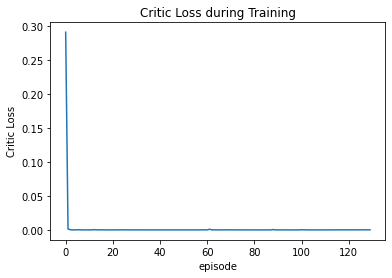

In [9]:
# Plot the Critic loss during training (optional)
plt.plot(critic_losses)
plt.xlabel('episode')
plt.ylabel('Critic Loss')
plt.title('Critic Loss during Training')
plt.savefig('critic_losses.eps', format='eps')
plt.show()

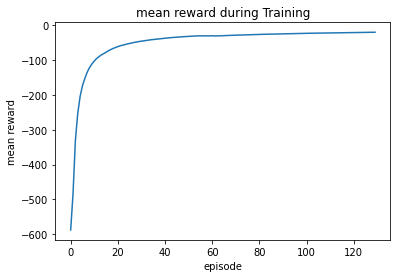

In [10]:
plt.plot(mean_reward)
plt.xlabel('episode')
plt.ylabel('mean reward')
plt.title('mean reward during Training')
plt.savefig('mean_reward.eps', format='eps')
plt.show()

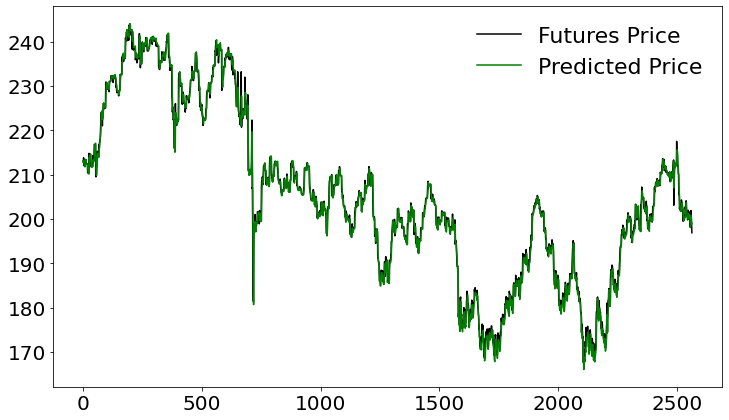

In [11]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(test_a, label='Futures Price',color='black')
ax.plot(pred, label='Predicted Price',color='green')
#ax.plot(pd.to_datetime(data['DATETIME']),testPredictPlot,label='test predict')
#ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#ax.set_title(f"{stock} on {date} Cumulative trades / ADV", fontsize=25)
#plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
plt.show() 

In [12]:
df1 = raw_df.copy()
df1=df1[-len(pred):]
df1=df1.reset_index(drop=True)
df1['testPredict']=pred[0:]

In [13]:
df1[['Date', 'Time']] = df1['DATETIME'].str.split(' ', 1, expand=True)
#df1=pd.DataFrame()

#df1 = df1.loc[df['DATETIME'].str.contains('16:00:00')]
df1['Return']= df1['PRICE'].pct_change() 
df1['Predict Return']= df1['Return']*np.sign(df1['testPredict']-df1["PRICE"].shift(1)) 
df1['Cumulative Return'] = ((1 + df1['Return'])).cumprod()-1
df1=df1.set_index('Date')

df1['actual_diff']=df1['PRICE']-df1['PRICE'].shift(1)
df1['diff']=df1['testPredict']-df1['PRICE'].shift(1)

df1['label'] = (df1['actual_diff'] > 0).astype(int) 
df1['pred_label']=(df1['diff'] > 0).astype(int)

Volatility=np.std(df1['Predict Return']) 

/var/folders/vj/hl44tyxn2t1ccmc23733qvlh0000gn/T/ipykernel_25937/2960932371.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df1[['Date', 'Time']] = df1['DATETIME'].str.split(' ', 1, expand=True)


In [15]:
df1['pred_label'][-2532:].to_csv('rl_pred_label.csv', index=False)